# Import Packages and Data

In [43]:
# Import packages

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [44]:
# Import data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data', header=None)

# Assign column names 
df.columns = ['Wife Age', 'Wife Education', 'Husband Education', 'Number of Children', 'Wife Religion', 'Wife Working', 'Husband Occupation', 'Standard of Living', 'Media Exposure', 'Contraceptive Method Used']
cols = ['Wife Age', 'Wife Education', 'Husband Education', 'Number of Children', 'Wife Religion', 'Wife Working', 'Husband Occupation', 'Standard of Living', 'Media Exposure', 'Contraceptive Method Used']
df.head()

,Wife Age,Wife Education,Husband Education,Number of Children,Wife Religion,Wife Working,Husband Occupation,Standard of Living,Media Exposure,Contraceptive Method Used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


# Data Preprocessing

**EXPLORATORY DATA ANALYSIS**

In preparation for fitting a logistic regression model to our data, one assumption requires there to be little to no multicollinearity between predictor variables. To test this assumption, we plotted the correlation coefficients below, and our results show no significant multicollinearity, so this does not pose a concern in fitting our model.

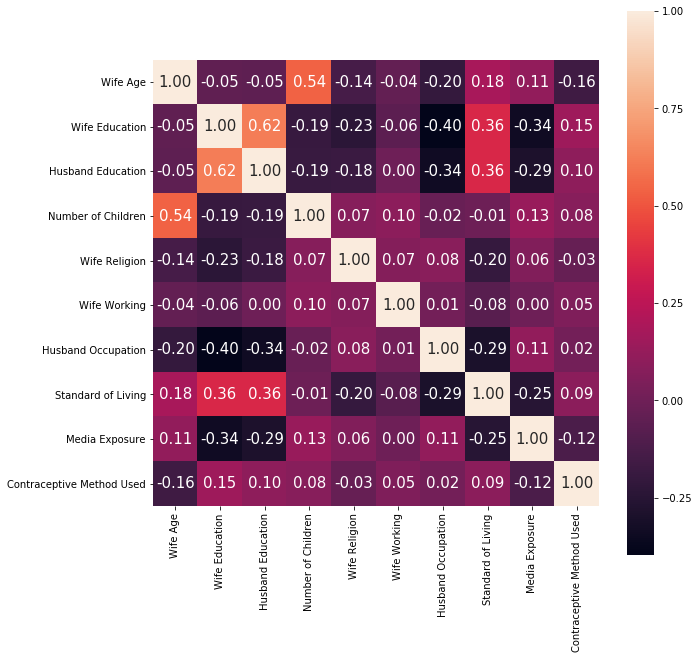

In [45]:
# Get pearson product-moment correlation coefficients
cm = np.corrcoef(df[cols].values.T)

# Plot heat map
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.show()

**DATA PRE-PROCESSING**

In [46]:
# Check for missing values = no missing values
df.isnull().sum()

# Assign predictor variables:
# Wife Age, Wife Education, Husband Education, Number of Children, 
# Wife Religion, Wife Working, Husband Occupation, Standard of Living
# Media Exposure
X = df.iloc[:, :-1].values

# Assign target variables: Contraceptive Method Used 
# Convert 2d array to 1d
y = df.iloc[:, -1:].values.ravel()

# Randomly choose 70% of the data for training and 30% for testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Feature Selection Using Random Forest

**Model Specifications:** 
- n_estimators = 25 (ideally want to calculate as many decision trees as your computer can handle)

**Model Accuracy on Original Data (Accuracy Test):** When we first train/test our RCF on our original data, we get a train accuracy = 0.966 and a test accuracy = 0.52. From the significant difference between these results, we can see that the training model overfit the data, and therefore, doesn't generalize well to new data.

**Model Accuracy on Original Data (Fscore Test):** In addition, we calculated the fscore of our predicted values to measure our test models' accuracy and, as expected, we got the same predictive value to our accuracy test of about 0.52

In [47]:
# Initiate random forest classifier
rfc = RandomForestClassifier(random_state=0, n_estimators=25)

# Train the model 
rfc.fit(X_train, y_train)

# Predict model
y_pred_rfc = rfc.predict(X_test)

#Accuracy Tests

# Train and test model accuracy
print('Train Accuracy:', metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test Accuracy:', metrics.accuracy_score(y_test, rfc.predict(X_test)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_rfc, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_pred_rfc))

#Cross-Validation

Train Accuracy: 0.9660523763336566
Test Accuracy: 0.5203619909502263
Fscore: 0.5203619909502263
             precision    recall  f1-score   support

          1       0.59      0.64      0.61       189
          2       0.44      0.40      0.42       100
          3       0.48      0.45      0.46       153

avg / total       0.52      0.52      0.52       442



**Feature Importances:** One benefit to RFC's is that it can estimate the feature importances. To get this estimate, we first have to fit the RFC to the data. You can see below the rank of feature importances, with "Wife Age" being the most significant in explaining contraceptive use, followed by "Num. of Children", "Wife Educ.", etc. Now that we have the feature importances in order of significance, we can re-train and test our model starting with the most significant feature and incrementally include the second, third, etc. to see which subset of features produces the best model with the most predictive power. 

Wife Age              0.343427
Number of Children    0.221656
Wife Education        0.092130
Standard of Living    0.091691
Husband Occupation    0.087044
Husband Education     0.070569
Wife Working          0.045922
Wife Religion         0.031195
Media Exposure        0.016367
dtype: float64


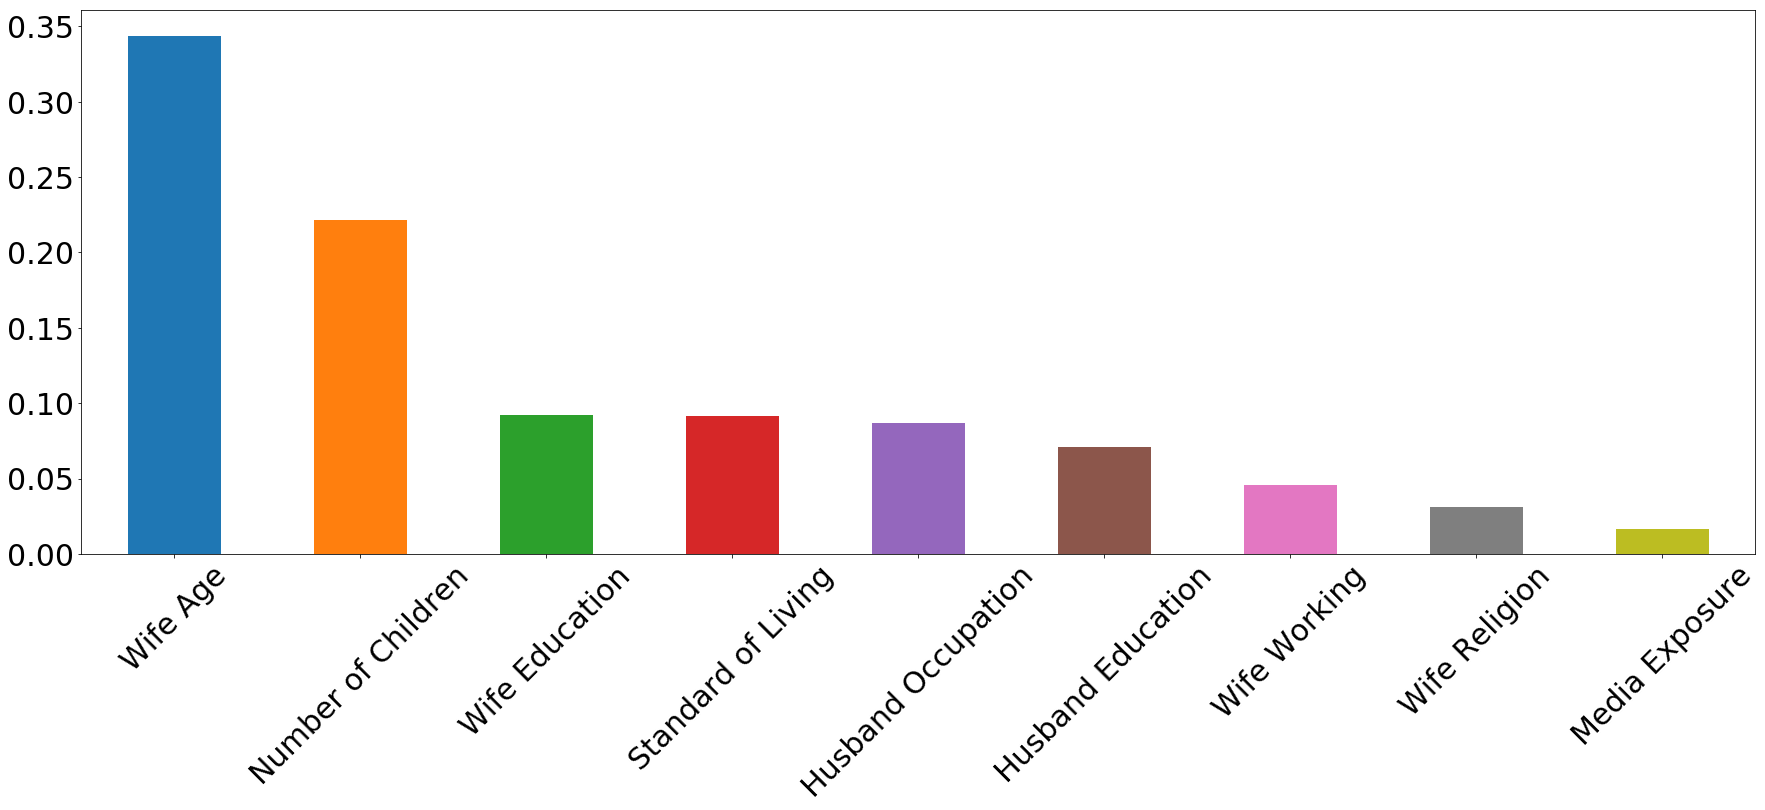

In [48]:
# Get the feature importances
importances = rfc.feature_importances_
# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, df.columns[:-1])
# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)
print(f_importances)

# Plot feature importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(30,10), rot=45, fontsize=30)
#plt.tight_layout()
plt.show()

In [49]:
# Feature selection - evaluate most significant features for random forest classifier   
f_importances_ = []
fscores = []
#f_cols = [0,1,2,3,4,5,6,7,8]
f_cols = [0,3,1,7,6,2,5,4,8]
for k in range(1,10):
    # declare model
    rfc = RandomForestClassifier(random_state=0, n_estimators=25)
    
    # train model
    rfc.fit(X_train[:,f_cols[0:k]], y_train)
    
    # get feature importances
    importances = rfc.feature_importances_.tolist()

    # test model
    y_pred = rfc.predict(X_test[:,f_cols[0:k]])
 
    # Get precision, recall, fscore, and support
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro')
    f_importances_.append(importances)
    fscores.append(fscore)

print('Fscores:', fscores)

Fscores: [0.45475113122171945, 0.4819004524886878, 0.504524886877828, 0.5429864253393665, 0.5294117647058824, 0.5135746606334841, 0.5226244343891403, 0.5361990950226244, 0.5090497737556561]


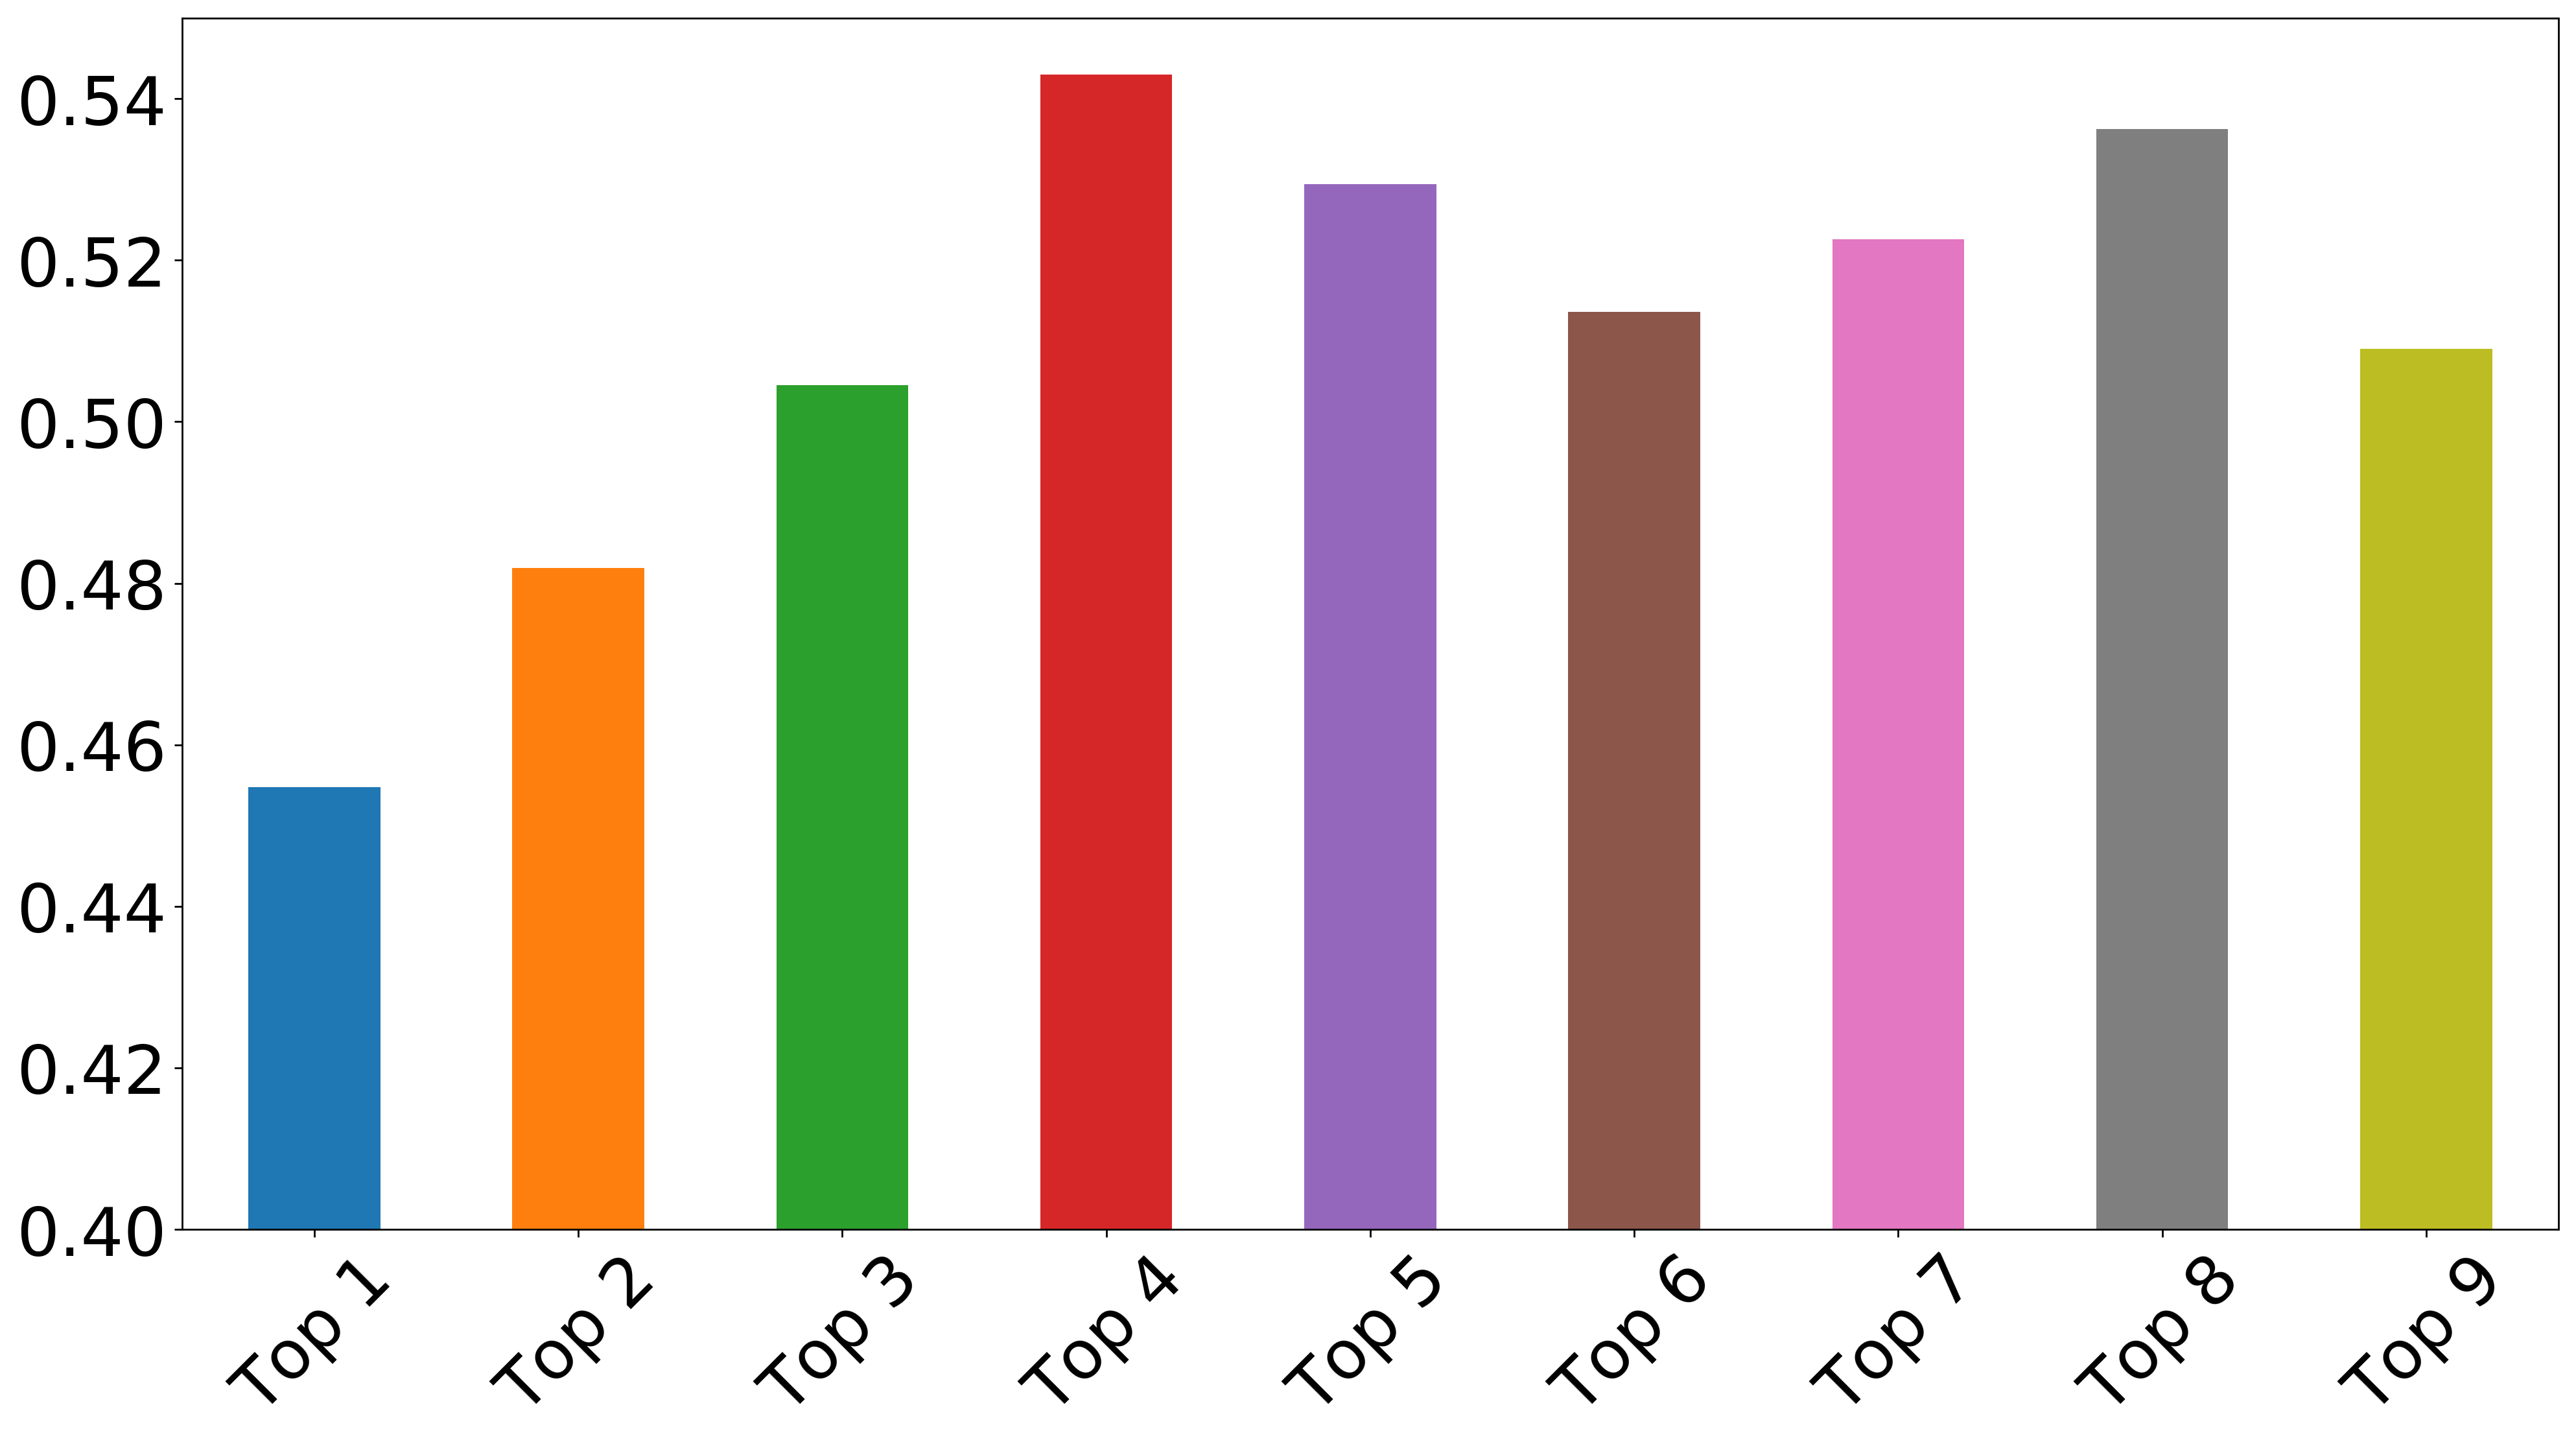

In [50]:
# Convert the fscores into one-dimensional 1darray with corresponding classifier names as axis labels
rf_fscores = pd.Series(fscores, ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5', 'Top 6', 'Top 7', 'Top 8', 'Top 9'])

# Plot top k features fscores
plt.figure(figsize=(16,9),dpi=250)
rf_fscores.plot(x='Features', y='Importance', kind='bar', fontsize=30, rot=45)
plt.ylim(0.4, 0.55)
plt.tight_layout()
plt.show()

After anlayzing the fscores from the top k features above, we can see the best predictive model contains our top 4 features [Wife Age, Num of Children, Wife Educ, SOL]. Next, we will retrain our rcf model using only those top 4 features to see it results in a better train/test accuracy.  

# Random Forest Classifier

**Model PROS:** 
- Not affected by multicollinearity 
- Low variance, so not susceptible to overfitting like decision trees
- Works well with large amount of features
- Provides estimates of feature importance

**Model CONS:**
- For categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels
- Relatively difficult to interpret

**Model Accuracy on Subset Feature Importances (Fscore):** Once we re-fit/train our data on the sorted feature importances below, we can see that our model has the largest fscore/best testing accuracy of about 0.543 with it only including the top 4 features [wife age, number of children, wife education, standard of living]. You can see in the results below that the train accuracy has decreased to about 0.85 and the test accuracy has increased to about 0.54 from our original rcf model (above) using the total amount of features.

In [51]:
#Retrain model using top 4 features from feature selection

#Subset data to only contain [Wife Age, Num of Children, Wife Educ, SOL]
subset_X_train = X_train[:,[0,3,1,7]]
subset_X_test = X_test[:,[0,3,1,7]]

# Train the model 
rfc.fit(subset_X_train, y_train)

# Predict model
y_pred_topk = rfc.predict(subset_X_test)

#Accuracy Tests

# Train and test model accuracy
print('Train Accuracy:', metrics.accuracy_score(y_train, rfc.predict(subset_X_train)))
print('Test Accuracy:', metrics.accuracy_score(y_test, rfc.predict(subset_X_test)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_topk, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_pred_topk))

#Cross-Validation

Train Accuracy: 0.8486905916585838
Test Accuracy: 0.5429864253393665
Fscore: 0.5429864253393665
             precision    recall  f1-score   support

          1       0.64      0.65      0.64       189
          2       0.42      0.38      0.40       100
          3       0.50      0.52      0.51       153

avg / total       0.54      0.54      0.54       442



# Multinomial Logistic Regression

**Scaling Assumptions:** While scaling the data is not necessary for multinomial logistic regression, when using gradient descent to fit our model, standardization does help speed up the convergence. Furthermore, since we are using L2 regularization it assumes that all features are centered around 0 and have variance in the same order.

**Model Specifications:** Our first model we fit is a logistic regression model. Since we have 3 target classes instead of 2, we implemented a multinomial parameter to account for the additional target variables. Additionally, we implemented a L2 penalty parameter prevent overfitting and simplify our model. L2 regularization works by biasing the data towards smaller values and penalizing high-valued coefficients by adding the sum of their squared values to the error term, which reduces their weights.

**Model PROS:**
- Robust to small noise in the data
- Not affected by mild cases of multicollinearity (can be countered with L2 regularization to an extent if multicollinearity presents itself)

**Model CONS:**
- Doesn't handle large number of categorical features/variables well (our data is mainly categorical)

In [52]:
# Run Logistic Regression model using all features
# Initiate standard scaler for standardization 
sc = StandardScaler()

# Standardize X train and X test
X_train_std = sc.fit_transform(X_train.astype(float))
X_test_std = sc.transform(X_test.astype(float))

# Initiate multi-class logistic regression model 
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2', C=1.0, random_state=0)

# Train model
mul_lr.fit(X_train_std, y_train)

# Test model
y_test_pred = mul_lr.predict(X_test_std)


**Model Accuracy (Accuracy Score Test):** We looked at the train and test model accuracy, and our results show train accuracy = 0.54 and test accuracy = 0.50. The accuracy scores calculate how well each model correctly predicts each target class. You can see the train and test accuracy scores are relatively close, suggesting that our model did a good job not over/underfitting our data, however the overall low scores of around 50% suggest our explanatory variables do not explain contraceptive use well. Thus, we would need additional explanatory variables to better explain this relationship.

**Model Accuracy (Fscore Test):** In addition, we calculated the fscore of our predicted values to measure our test models' accuracy and, as expected, we got a similar value of about 0.504. This fscore calculation is an average of the precision (correct positive predictions/total positive predictions) and recall (correct positive predictions/wrong negative predictions) values. So, fscore best at 1 and worst at 0. 

**Model Accuracy (Cross-Validation):** To reassure we are not under or overfitting our model we want to perform cross-validation. Because our cross-validation average accuracy score is close to our training and testing accuracy, we can conclude that we are not seeing under or overfitting of our model.

In [53]:
# Train and test model accuracy
print('Train Accuracy:', metrics.accuracy_score(y_train, mul_lr.predict(X_train_std)))
print('Test Accuracy:', metrics.accuracy_score(y_test, mul_lr.predict(X_test_std)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_test_pred))

#Perform k-fold cross-validation with 3 folds
kfold = model_selection.KFold(n_splits=3, random_state=7)
model_lr = LogisticRegression()
scoring = 'accuracy'
results_lr = model_selection.cross_val_score(model_lr, X_train_std, y_train, cv=kfold, scoring=scoring)
print("3-fold cross validation average accuracy: %0.2f (+/- %0.2f)" % (results_lr.mean(), results_lr.std() * 2))

# Coefficients 
#mul_lr.coef_

Train Accuracy: 0.5431619786614937
Test Accuracy: 0.504524886877828
Fscore: 0.504524886877828
             precision    recall  f1-score   support

          1       0.58      0.65      0.61       189
          2       0.47      0.35      0.40       100
          3       0.42      0.43      0.43       153

avg / total       0.50      0.50      0.50       442

3-fold cross validation average accuracy: 0.52 (+/- 0.01)


In [54]:
# Run Logistic Regression model using top 4 features from feature selection
# Standardize  Subset X train and Subset X test
X_top_train_std = sc.fit_transform(subset_X_train.astype(float))
X_top_test_std = sc.transform(subset_X_test.astype(float))

# Initiate multi-class logistic regression model 
mul_lr_top = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2', C=1.0, random_state=0)

# Train model
mul_lr_top.fit(X_top_train_std, y_train)

# Test model
y_top_test_pred = mul_lr_top.predict(X_top_test_std)

In [55]:
# Train and test model accuracy
print('Train Accuracy:', metrics.accuracy_score(y_train, mul_lr_top.predict(X_top_train_std)))
print('Test Accuracy:', metrics.accuracy_score(y_test, mul_lr_top.predict(X_top_test_std)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_top_test_pred, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_top_test_pred))

Train Accuracy: 0.5315227934044617
Test Accuracy: 0.504524886877828
Fscore: 0.504524886877828
             precision    recall  f1-score   support

          1       0.57      0.62      0.59       189
          2       0.48      0.37      0.42       100
          3       0.43      0.45      0.44       153

avg / total       0.50      0.50      0.50       442



# K Nearest Neighbor

**Scaling Assumptions:** Because K nearest neighbor calculates the distance between data points as an indication of the labels of a "typical" target category, standardization is key. Again, we want to guard against different variances negatively impacting the learning of the algorithm and have all our features be unit independent. 

**Model PROS:**
- Insensitive to outliers
- Useful for non-linear data

**Model CONS:**
- Sensitive to irrelevant features

**Model Specifications:** In our application we chose k to be 36 because it is close to the rule of thumb of k = sqrt(n) where n is the number of samples in our training set. This value of k also maximized our testing accuracy while minimizing the difference in accuracy between our testing and training sets. Furthermore, a higher k is more resilient to outliers. 

In [56]:
# Train and test data with all features
#X_train_std = sc.fit_transform(X_train.astype(float))
#X_test_std = sc.transform(X_test.astype(float))

# Create the knn model
# Look at the 36 closest neighbors
knn = KNeighborsClassifier(n_neighbors=36,p=2, metric='minkowski')

# Fit the model on the training data
knn.fit(X_train_std, y_train)

# Predict the labels on X_test_std
y_pred_knn = knn.predict(X_test_std)

**Model Accuracy (Accuracy Score Test):** After fitting the model and applying it to predict our testing set, we find that our training accuracy is 0.552 and testing accuracy is 0.514. This means that while our model has generalized well, our data doesn't predict contraceptive use well. 

**Model Accuracy (Fscore Test):** We calculated the fscore of our predicted values to measure our test models' accuracy and we got a value of about 0.51.

**Model Accuracy (Cross-Validation):** When performing our cross-validation, we see that our accuracy score is .5 with a 95% confidence interval of +-.02 which is in the same range as our training and testing accuracy which means that our model isn't over or underfit. 

In [57]:
#print('Train accuracy:', knn.score(X_train_std, y_train))
#print('Test accuracy:', knn.score(X_test_std, y_test))
print('Train Accuracy:', metrics.accuracy_score(y_train, knn.predict(X_train_std)))
print('Test Accuracy:', metrics.accuracy_score(y_test, knn.predict(X_test_std)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_knn, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_pred_knn))

#Perform k-fold cross-validation with 2 folds
kfold = model_selection.KFold(n_splits=2, random_state=7)
model_knn = KNeighborsClassifier(n_neighbors=36,p=2, metric='minkowski')
scoring = 'accuracy'
results_knn = model_selection.cross_val_score(model_knn, X_train_std, y_train, cv=kfold, scoring=scoring)
print("2-fold cross validation average accuracy: %0.2f (+/- %0.2f)" % (results_knn.mean(), results_knn.std() * 2))

Train Accuracy: 0.5518913676042677
Test Accuracy: 0.5135746606334841
Fscore: 0.5135746606334841
             precision    recall  f1-score   support

          1       0.60      0.60      0.60       189
          2       0.39      0.43      0.41       100
          3       0.50      0.46      0.48       153

avg / total       0.52      0.51      0.51       442

2-fold cross validation average accuracy: 0.51 (+/- 0.00)


In [58]:
# Train and test data with top 4 features from feature selection
#X_top_train_std = sc.fit_transform(subset_X_train.astype(float))
#X_top_test_std = sc.transform(subset_X_test.astype(float))

# Create the knn model
# Look at the 36 closest neighbors
knn_top = KNeighborsClassifier(n_neighbors=36,p=2, metric='minkowski')

# Fit the model on the training data
knn_top.fit(X_top_train_std, y_train)

# Predict the labels on X_test_std
y_top_pred_knn = knn_top.predict(X_top_test_std)

In [59]:
#print('Train accuracy:', knn.score(X_train_std, y_train))
#print('Test accuracy:', knn.score(X_test_std, y_test))
print('Train Accuracy:', metrics.accuracy_score(y_train, knn_top.predict(X_top_train_std)))
print('Test Accuracy:', metrics.accuracy_score(y_test, knn_top.predict(X_top_test_std)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_top_pred_knn, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_top_pred_knn))

Train Accuracy: 0.5897187196896218
Test Accuracy: 0.5316742081447964
Fscore: 0.5316742081447964
             precision    recall  f1-score   support

          1       0.60      0.67      0.63       189
          2       0.45      0.35      0.40       100
          3       0.48      0.48      0.48       153

avg / total       0.52      0.53      0.53       442



# Support Vector Machines

**Scaling Assumptions:** For SVM, standardization of data is critical because input variables are combined via a distance function in a RBF kernel. In other words, the contribution of an input will depend heavily on its variability relative to other inputs. If the variance of one input variable is much greater than another, it may dominate the objective function and make the estimator unable to learn from other features correctly as expected.

**Model PROS:** 
- Robust algorithm
- Works well on smaller, cleaner datasets and can be more efficient because it uses a subset of the training points. 
- Because of convex optimization, the solution will definitely be the global minimum and not the local minimum. 
- Useful for both linearly separable and non-linearly separable data and in the case of non-linearly separable data we are able to use the kernel trick so that the data may be linearly separable in higher dimensional space. 

**Model CONS:**
- Unfortunately, it is less effective on noisier data that have overlapping classes. 

**Model Specifications:** We chose to use the RBF kernel because it maps to infinite dimensional space and is best for non-linearly separable data. In our case we chose gamma to be .08 and C to be 1 because we want the impact of a single training example to be great and a smoother decision surface. These choices also represent an effective trade off between the two values in terms of maximizing the accuracy of our model. 

In [60]:
# Run SVM model on all features
# Initiate SVM model
svm = SVC(kernel='rbf', random_state=1, decision_function_shape = 'ovo', gamma=.08, C=1.0)

# Fit the model on the training data
svm.fit(X_train_std, y_train)

# Predict the labels on X_test_std
y_pred_svm = svm.predict(X_test_std)

**Model Accuracy (Accuracy Score):** After implementing our model we find that our training accuracy is 0.626 and our testing accuracy is 0.55. Again our model generalizes fairly well (although not as well as in other models) and we were able to get a higher test accuracy than in other models. 

**Model Accuracy (Fscore Test):** We calculated the fscore of our predicted values to measure our test models' accuracy and we got a value of about 0.55.

**Model Accuracy (Cross-Validation):** When we run cross-validation we get an accuracy of .57 with a 95% interval of +- .03 which is in a similar range as our other accuracy scores so we are not over or underfitting. 

In [61]:
# Train and test accuracy scores on all features
#print('Train accuracy:', svm.score(X_train_std, y_train))
#print('Test accuracy:', svm.score(X_test_std, y_test))
print('Train Accuracy:', metrics.accuracy_score(y_train, svm.predict(X_train_std)))
print('Test Accuracy:', metrics.accuracy_score(y_test, svm.predict(X_test_std)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_svm, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_pred_svm))

#Perform k-fold cross-validation with 3 folds
kfold = model_selection.KFold(n_splits=3, random_state=7)
model_svm = SVC(kernel='rbf', random_state=1, gamma=.08, C=1.0)
scoring = 'accuracy'
results_svm = model_selection.cross_val_score(model_svm, X_train_std, y_train, cv=kfold, scoring=scoring)
print("3-fold cross validation average accuracy: %0.2f (+/- %0.2f)" % (results_svm.mean(), results_svm.std() * 2))

Train Accuracy: 0.6256062075654704
Test Accuracy: 0.5497737556561086
Fscore: 0.5497737556561086
             precision    recall  f1-score   support

          1       0.62      0.68      0.65       189
          2       0.45      0.33      0.38       100
          3       0.51      0.53      0.52       153

avg / total       0.54      0.55      0.54       442

3-fold cross validation average accuracy: 0.57 (+/- 0.03)


In [62]:
# Run SVM model on top 4 features from feature selection
# Initiate SVM model
svm_top = SVC(kernel='rbf', random_state=1, decision_function_shape = 'ovo', gamma=.08, C=1.0)

# Fit the model on the training data
svm_top.fit(X_top_train_std, y_train)

# Predict the labels on X_test_std
y_top_pred_svm = svm_top.predict(X_top_test_std)

In [63]:
# Train and test accuracy scores on top 4 features from feature selection
#print('Train accuracy:', svm.score(X_train_std, y_train))
#print('Test accuracy:', svm.score(X_test_std, y_test))
print('Train Accuracy:', metrics.accuracy_score(y_train, svm_top.predict(X_top_train_std)))
print('Test Accuracy:', metrics.accuracy_score(y_test, svm_top.predict(X_top_test_std)))

# Calculate precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_top_pred_svm, average='micro')
print('Fscore:', fscore)

# Classification report
print(classification_report(y_test, y_top_pred_svm))

Train Accuracy: 0.5868089233753637
Test Accuracy: 0.5361990950226244
Fscore: 0.5361990950226244
             precision    recall  f1-score   support

          1       0.60      0.66      0.63       189
          2       0.52      0.31      0.39       100
          3       0.47      0.54      0.50       153

avg / total       0.54      0.54      0.53       442



# Best Classifier 

The fscore results below show the predictive accuracy of each of our classifier models, and SVM predicts contraceptive use all the best using the explanatory variables. 

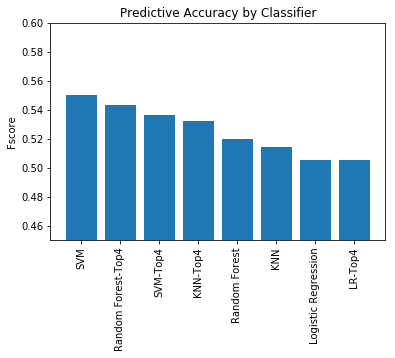

In [67]:
# Plot best classifier 

classifiers = ('SVM', 'Random Forest-Top4', 'SVM-Top4', 'KNN-Top4', 'Random Forest', 'KNN', 'Logistic Regression', 'LR-Top4')
y_pos = np.arange(len(classifiers))
fscore = [0.55,0.543,0.536,0.532,0.520,0.514,0.505,0.505]

plt.bar(y_pos, fscore, align='center')
plt.xticks(y_pos, classifiers, rotation=90)
plt.ylabel('Fscore')
plt.title('Predictive Accuracy by Classifier')
plt.ylim(0.45, 0.6)
 
plt.show()

# Results

As our best classifier section shows, SVM did the best at predicting our testing set. One of the big reasons that SVM did well is because it can deal with non-linearly separable data unlike logistic regression. Furthermore, because we have several dimensions, SVM does better with high dimensional space. The non-linearity of our data is also a reason why random forest performed well because it does not expect a linear relationship between features. Logistic regression was our worst performing model because it assumes linearly separable data, linear relationships, and it doesn't perform well with binary and categorical data which we mostly have. Because k-nearest neighbor didn't perform as well as SVM it suggests that our classes are not easily separable. However, when isolated to the top 4 features, KNN and SVM perform very similarly since KNN does better in low-dimensions. 